### GradientBoosting (grad)
#### fit previous errors
##### First model is "DummyRegressor"

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [13]:
from scipy.special import expit
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

class GradientBoosting:
    def __init__(self, S=5, learning_rate=1, max_depth = 1, 
                 min_samples_split = 2,
                 regression=True, tol=1e-4):
        self.S = S
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.regression = regression
            
        #initialize regression trees
        tree_params = {'max_depth': self.max_depth,
                      'min_samples_split': self.min_samples_split}
        self.models = [DecisionTreeRegressor(**tree_params) for _ in range(S)]        
        first_model = DummyRegressor(strategy='mean') # or ("constant" set to 0)
        self.models.insert(0, first_model) #insert the first model at 0th 
        
    def grad(self, y, h):
        return y - h
    
    def fit(self, X, y):  #<----X_train
        
        #fit the first model
        self.models[0].fit(X, y)
        
        for i in range(self.S):
            #predict
            yhat = self.predict(X, self.models[:i+1], with_argmax=False)
            
            #get the gradient
            gradient = self.grad(y, yhat)
            
            #fit the next model with gradient
            self.models[i+1].fit(X, gradient)
    
    def predict(self, X, models=None, with_argmax=True):
        if models is None:
            models = self.models
        h0 = models[0].predict(X)  #first use the dummy model
        boosting = sum(self.learning_rate * model.predict(X) for model in models[1:])
        yhat = h0 + boosting
        if not self.regression:
            #turn into probability using softmax
            yhat = np.exp(yhat) / np.sum(np.exp(yhat), axis=1, keepdims=True)
            if with_argmax:
                yhat = np.argmax(yhat, axis=1)
        return yhat


## 1.Regression

#### 1.1 scratch

In [14]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        test_size=0.3, random_state=42)

model = GradientBoosting(S=200, learning_rate=0.1, max_depth = 3, 
                 min_samples_split = 2,
                 regression=True, tol=1e-4)
model.fit(X_train, y_train)
yhat = model.predict(X_test)

#print metrics
print("MSE: ", mean_squared_error(y_test, yhat))

MSE:  8.13133052101731


#### 1.2 Sklearn

In [16]:
#Compare to sklearn: ls is the same as our mse
n_estimators = 200
#The number of boosting stages to perform. 
#Gradient boosting is fairly robust to over-fitting 
#so a large number usually results in better performance.

sklearn_model = GradientBoostingRegressor(
    n_estimators=n_estimators,
    learning_rate = 0.1,
    max_depth=3,
    loss='ls'
)

yhat_sk = sklearn_model.fit(X_train, y_train).predict(X_test)
print("Sklearn MSE: ", mean_squared_error(y_test, yhat_sk))

Sklearn MSE:  7.895907181600773


### 2. Binary Classification (regression = False)

#### 2.1 Scratch

In [47]:
## Test with Matt's donut data

In [48]:
# Generate data for class 1

mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)

# Generate data for class 2

angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)
X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T

# Combine X1 and X2 into single dataset

X = np.concatenate([X1, X2],axis = 0)
y = np.append(np.zeros(num_sample),np.ones(num_sample))


In [49]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

# X, y = load_breast_cancer(return_X_y=True)

# X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.3, random_state=42)

y_train_encoded = np.zeros((y_train.shape[0], len(set(y))))

for each_class in range(len(set(y))):
    cond = y_train==each_class
    y_train_encoded[np.where(cond), each_class] = 1

model = GradientBoosting(S=200, learning_rate=0.1, max_depth = 3, 
                 min_samples_split = 2,
                 regression=False) #regression = False

model.fit(X_train, y_train_encoded)
yhat = model.predict(X_test)

# #print metrics
print("Our accuracy: ", accuracy_score(y_test, yhat))

Our accuracy:  1.0


(200, 200)
(200, 200)


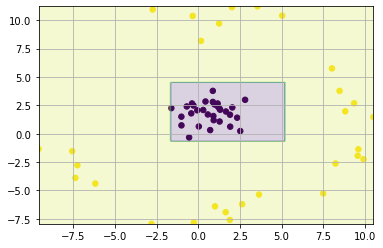

In [53]:
def plot_tree(model, X, y):
    plt.grid()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30)
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=200),
                             np.linspace(np.min(X[:,1]), np.max(X[:,1]), num=200))
    print(xx.shape)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    print(Z.shape)
    # Create a color plot with the results
    n_classes = len(set(y))
    contours = plt.contourf(xx, yy, Z, alpha=0.2)

# model = AdaBoost(S=10)
# model.fit(X_train[:,:2],y_train)
# yhat = model.predict(X_test[:,:2])

plot_tree(model, X_test, y_test)

#### 2.2 Sklearn

In [51]:
#Compare to sklearn: ls is the same as our accuracy
sklearn_model = GradientBoostingClassifier(
    n_estimators=n_estimators,
    learning_rate = 0.1,
    max_depth=1
)

yhat_sk = sklearn_model.fit(X_train, y_train).predict(X_test)
print("Sklearn accuracy: ", accuracy_score(y_test, yhat_sk))

Sklearn accuracy:  1.0


(200, 200)
(200, 200)


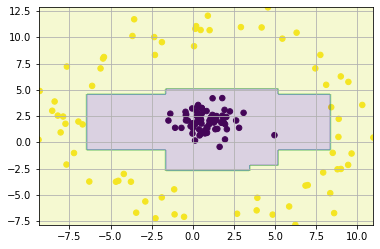

In [52]:
def plot_tree(model, X, y):
    plt.grid()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30)
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=200),
                             np.linspace(np.min(X[:,1]), np.max(X[:,1]), num=200))
    print(xx.shape)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    print(Z.shape)
    # Create a color plot with the results
    n_classes = len(set(y))
    contours = plt.contourf(xx, yy, Z, alpha=0.2)

# model = AdaBoost(S=10)
# model.fit(X_train[:,:2],y_train)
# yhat = model.predict(X_test[:,:2])

plot_tree(sklearn_model, X_test, y_test)

### 3. Multinomial Classification (regression = False)

#### 3.1 Scratch

In [37]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

X, y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.3, random_state=42)

y_train_encoded = np.zeros((y_train.shape[0], len(set(y))))

for each_class in range(len(set(y))):
    cond = y_train==each_class
    y_train_encoded[np.where(cond), each_class] = 1

model = GradientBoosting(S=200, learning_rate=0.1, max_depth = 3, 
                 min_samples_split = 2,
                 regression=False)

model.fit(X_train, y_train_encoded)
yhat = model.predict(X_test)

# #print metrics
print("Our accuracy: ", accuracy_score(y_test, yhat))

Our accuracy:  0.9314814814814815


#### 3.2 Sklearn

In [38]:
#Compare to sklearn: ls is the same as our accuracy
sklearn_model = GradientBoostingClassifier(
    n_estimators=n_estimators,
    learning_rate = 0.1,
    max_depth=1
)

yhat_sk = sklearn_model.fit(X_train, y_train).predict(X_test)
print("Sklearn accuracy: ", accuracy_score(y_test, yhat_sk))

Sklearn accuracy:  0.9481481481481482
